In [1]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import *
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Set max rows and columns display
pd.set_option("display.max_columns", None)

## Load Datasets

In [3]:
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')
weather = pd.read_csv('weather_cleaned.csv')
spray = pd.read_csv('spray_cleaned.csv')

## Pre-processing

In [4]:
test.head(1)

,id,date,address,species,block,trap,latitude,longitude,addressaccuracy,year,month,week,day,day_of_week
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,T002,41.95469,-87.800991,9,2008,6,24,11,2


In [5]:
train.head(1)

,date,address,species,block,trap,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,day,day_of_week
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,T002,41.95469,-87.800991,9,1,0,2007,5,22,29,1


In [6]:
weather.head(1)

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,day,day_of_week
0,1,2007-05-01,83,50,67,51,56,0,2,448,1849,0.0,29.1,29.82,1.7,27,9.2,2007,5,18,1,1


### Drop unnecessary columns

In [7]:
target = train['wnvpresent']
train.drop(['address','wnvpresent','nummosquitos','addressaccuracy',], axis=1, inplace=True)
test.drop(['address','addressaccuracy',], axis=1, inplace=True)
weather.drop(['year','month','week','day','day_of_week'], axis=1, inplace=True)

### Average Station Data

In [8]:
weather.groupby('station')['station'].count()

station
1    1472
2    1472
Name: station, dtype: int64

In [9]:
# weather = wx.groupby(by='date',as_index = False).mean().drop(columns='station')
# print(weather.shape)
# weather.head()

In [10]:
weather_stn1 = weather[weather['station']==1]
weather_stn2 = weather[weather['station']==2]
weather_stn1 = weather_stn1.drop('station', axis=1)
weather_stn2 = weather_stn2.drop('station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='date')

### OHE

In [11]:
# define list of categorical features
train_cat = ['species','trap']
train_cat

['species', 'trap']

In [12]:
# Use OneHotEncoder
# instantiate the OHE
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# fit OHE to features
ohe.fit(train[train_cat])

# create dummy array
transformed = ohe.transform(train[train_cat])

# input column names
column_name = ohe.get_feature_names_out(train_cat)

# rebuild dataframe and drop redundant columns
train = pd.concat([train, pd.DataFrame(transformed, columns=column_name)], axis=1)
train.drop(train_cat, axis=1, inplace=True)
train.head()

,date,block,latitude,longitude,year,month,week,day,day_of_week,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,2007-05-29,41,41.954690,-87.800991,2007,5,22,29,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007-05-29,41,41.954690,-87.800991,2007,5,22,29,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2007-05-29,62,41.994991,-87.769279,2007,5,22,29,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2007-05-29,79,41.974089,-87.824812,2007,5,22,29,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Merge

In [13]:
train = train.merge(weather, on='date')

In [14]:
train.drop('date', axis=1, inplace=True)
train

,block,latitude,longitude,year,month,week,day,day_of_week,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,tmax_x,tmin_x,tavg_x,dewpoint_x,wetbulb_x,heat_x,cool_x,sunrise_x,sunset_x,preciptotal_x,stnpressure_x,sealevel_x,resultspeed_x,resultdir_x,avgspeed_x,tmax_y,tmin_y,tavg_y,dewpoint_y,wetbulb_y,heat_y,cool_y,sunrise_y,sunset_y,preciptotal_y,stnpressure_y,sealevel_y,resultspeed_y,resultdir_y,avgspeed_y
0,41,41.954690,-87.800991,2007,5,22,29,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88,60,74,58,65,0,9,421,1917,0.0,29.39,30.11,5.8,18,6.5,88,65,77,59,66,0,12,421,1917,0.0,29.44,30.09,5.8,16,7.4
1,41,41.954690,-87.800991,2007,5,22,29,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88,60,74,58,65,0,9,421,1917,0.0,29.39,30.11,5.8,18,6.5,88,65,77,59,66,0,12,421,1917,0.0,29.44,30.09,5.8,16,7.4
2,62,41.994991,-87.769279,2007,5,22,29,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88,60,74,58,65,0,9,421,1917,0.0,29.39,30.11,5

In [15]:
train.shape

(10506, 181)

### Feature Engineering

In [16]:
# For later. better to run through the entire workflow first

### Train Test Split

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.25, random_state=42)

### Upsampling Using SMOTE
Only done on train

In [18]:
y_train.value_counts()

0    7462
1     417
Name: wnvpresent, dtype: int64

Unabalanced classes lead to misleading metric scores. SMOTE will thus be used to balance out the classes.

In [19]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [20]:
print('After SMOTE:')
print(y_train_sm.value_counts())
print(X_train_sm.shape)

After SMOTE:
1    7462
0    7462
Name: wnvpresent, dtype: int64
(14924, 181)


## Models

In [21]:
# scoring function
def model_results(model, X_train, y_train, X_valid, y_valid):
    print('Train accuracy: ', model.score(X_train, y_train))
    
    # classification report on test
    print('\n Classification report:')
    y_pred = model.predict(X_valid)
    print(classification_report(y_valid, y_pred))
    print('Label 1 is Presence of WNV')
    print('Label 0 is No presence of WNV')

### Random Forest

In [22]:
# clf = RandomForestClassifier(random_state=42)
# #clf.fit(X_train_sm, y_train_sm)

# rf_params = {
#     'n_estimators': [50, 100, 150, 200, 250],
#     'max_depth': [None, 3, 5, 7, 9],
# }

# gs = GridSearchCV(clf, param_grid=rf_params, cv=5, verbose=1, n_jobs=-1)
# gs.fit(X_train_sm, y_train_sm)
# print(gs.best_score_)
# gs.best_params_

In [23]:
clf = RandomForestClassifier(n_estimators=250, max_depth=None, random_state=42)
clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(n_estimators=250, random_state=42)

Train accuracy:  0.9715699961924102

 Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2493
           1       0.24      0.16      0.20       134

    accuracy                           0.93      2627
   macro avg       0.60      0.57      0.58      2627
weighted avg       0.92      0.93      0.92      2627

Label 1 is Presence of WNV
Label 0 is No presence of WNV


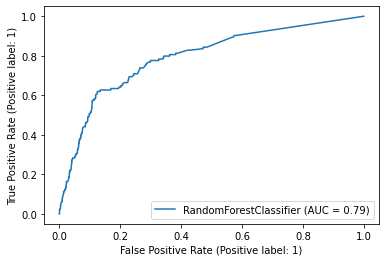

In [24]:
model_results(clf, X_train, y_train, X_valid, y_valid)
lr_disp = RocCurveDisplay.from_estimator(clf, X_valid, y_valid)

## Kaggle

In [25]:
# create dummy array
test_transformed = ohe.transform(test[train_cat])

# input column names
column_name = ohe.get_feature_names_out(train_cat)

# rebuild dataframe and drop redundant columns
test = pd.concat([test, pd.DataFrame(test_transformed, columns=column_name)], axis=1)
test.drop(train_cat, axis=1, inplace=True)
print(test.shape)
test.head()

(116293, 153)


,id,date,block,latitude,longitude,year,month,week,day,day_of_week,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,1,2008-06-11,41,41.95469,-87.800991,2008,6,24,11,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2008-06-11,41,41.95469,-87.800991,2008,6,24,11,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2008-06-11,41,41.95469,-87.800991,2008,6,24,11,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2008-06-11,41,41.95469,-87.800991,2008,6,24,11,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [26]:
test = test.merge(weather, on='date')

In [27]:
test.drop('date', axis=1, inplace=True)
test.head(2)

,id,block,latitude,longitude,year,month,week,day,day_of_week,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,tmax_x,tmin_x,tavg_x,dewpoint_x,wetbulb_x,heat_x,cool_x,sunrise_x,sunset_x,preciptotal_x,stnpressure_x,sealevel_x,resultspeed_x,resultdir_x,avgspeed_x,tmax_y,tmin_y,tavg_y,dewpoint_y,wetbulb_y,heat_y,cool_y,sunrise_y,sunset_y,preciptotal_y,stnpressure_y,sealevel_y,resultspeed_y,resultdir_y,avgspeed_y
0,1,41,41.95469,-87.800991,2008,6,24,11,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86,61,74,56,64,0,9,416,1926,0.0,29.28,29.99,8.9,18,10.0,86,66,76,55,64,0,11,416,1926,0.0,29.34,29.97,9.4,18,10.4
1,2,41,41.95469,-87.800991,2008,6,24,11,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86,61,74,56,64,0,9,416,1926,0.0,29.28,29.99,8.9,18,10.0,86,66,76,55,64,0,11,416,1926,0.0,29.34,29.97,9.4,18,10.4


In [28]:
# remove id column to get features only
X_test = test.drop(['id'], axis=1)

In [29]:
print(X_test.shape)
print(train.shape)

(116293, 181)
(10506, 181)


In [30]:
pred = clf.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
# rebuild dataframe in accordance with submission guidelines
submission_test = pd.DataFrame({'ID': test.id, 'WnvPresent': pred})
print(submission_test)

            ID  WnvPresent
0            1           0
1            2           0
2            3           0
3            4           0
4            5           0
...        ...         ...
116288  116289           0
116289  116290           0
116290  116291           0
116291  116292           0
116292  116293           0

[116293 rows x 2 columns]


In [32]:
submission_test.groupby('WnvPresent').count()

,ID
WnvPresent,
0,104513
1,11780


In [33]:
# save to csv for submission
submission_test.to_csv('test_sub.csv', index=False)